# But actually, we want to analyze repos 

In [67]:
import re
import matplotlib.pyplot as pyplot
import matplotlib
import time
from datetime import datetime
from multiprocessing import Pool
import multiprocessing
import functools

In [84]:
%load_ext autoreload
from repoLibrarian import *
%aimport repoLibrarian
%aimport repoAnalysis
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

In [85]:
repoLibrarian.setReposFolder('./repos/')

'./repos/'

In [5]:
getReposFolder()

'./repos/'

In [7]:
from os import listdir


def simpleRunMetric(metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    repos = list(map(lambda repo: (repo.split('/', 1)[0], repo.split('/', 1)[1]), knownRepos()))

    start = time.time()
    with Pool(int(multiprocessing.cpu_count())) as pool:
        allMetrics = pool.map(functools.partial(timedMetricPerFileForRepo, metricFunction=metricFunction, fileCountConsumer=fileCountConsumer), repos)
    end = time.time()
    print('Total Time used: '+str(end - start))
    return allMetrics

### Running metrics

In [23]:
allMetrics = simpleRunMetric(locmOf)

Time used for ('bptlab', 'fcm2cpn.git'): 0.32309722900390625
Time used for ('bptlab', 'correlation-analysis.git'): 6.87972354888916
Time used for ('bptlab', 'scylla.git'): 44.216235399246216
Time used for ('json-iterator', 'java.git'): 48.26174259185791
Time used for ('bptlab', 'cepta.git'): 61.69267416000366
Time used for ('bptlab', 'Unicorn.git'): 69.90817427635193
Time used for ('alibaba', 'arthas.git'): 191.63405680656433
Total Time used: 194.1722662448883


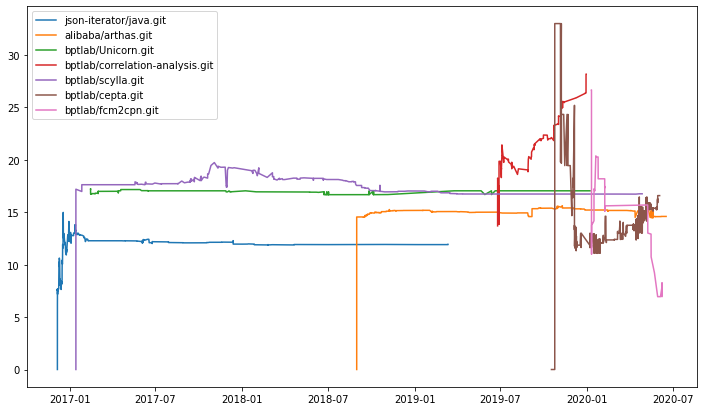

In [16]:
pyplot.figure(figsize=(12, 7))
for (timestamps, metrics) in allMetrics:
    dates = matplotlib.dates.epoch2num(timestamps)
    pyplot.plot_date(dates, metrics, '-')

pyplot.legend(list(knownRepos()))

Time used for ('bptlab', 'fcm2cpn.git'): 0.2428593635559082
Time used for ('bptlab', 'correlation-analysis.git'): 5.369837522506714
Time used for ('bptlab', 'scylla.git'): 23.692981958389282
Time used for ('json-iterator', 'java.git'): 25.463353395462036
Time used for ('bptlab', 'cepta.git'): 50.5887086391449
Time used for ('bptlab', 'Unicorn.git'): 52.17696785926819
Total Time used: 52.98057174682617


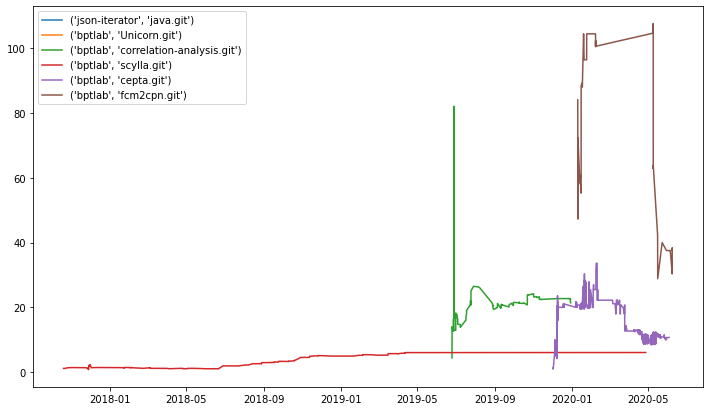

In [38]:
simpleRunMetric(lambdaDensity)

Time used for ('Elena-Zhao', 'Guimi.git'): 0.1284182071685791
Time used for ('Elena-Zhao', 'Mini-Chatter.git'): 0.10931038856506348
Time used for ('pleonex', 'ChatRMI.git'): 0.1066889762878418
Time used for ('craigslist206', 'huffman.git'): 0.16383004188537598
Time used for ('Elena-Zhao', 'Weibao.git'): 0.24792146682739258
Time used for ('pleonex', 'CocoKiller.git'): 0.2406604290008545
Time used for ('miken22', '304-Project.git'): 0.24741840362548828
Time used for ('bptlab', 'fcm2cpn.git'): 0.2866392135620117
Time used for ('pleonex', 'NiKate-Origins.git'): 0.39778637886047363
Time used for ('JTReed', 'Porygon.git'): 0.21101975440979004
Failed to analyze ('braliar', 'jabref.git'): Reference at 'refs/heads/master' does not exist
Time used for ('tyler124', 'Monitordroid.git'): 0.23861050605773926
Time used for ('GourdErwa', 'jasper_sample.git'): 0.2540762424468994
Time used for ('JTReed', 'Porygon2.git'): 0.4825553894042969
Time used for ('shengnwen', 'WeiBaoSSE.git'): 0.5534257888793945

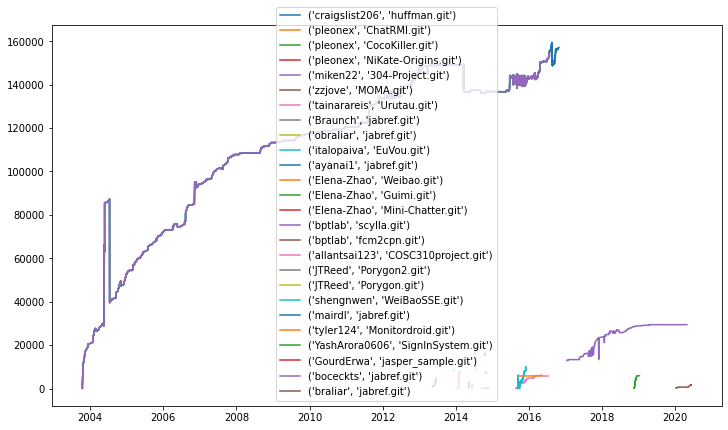

In [62]:
simpleRunMetric(loc, identity)

In [63]:
print(hasRepo('braliar','jabref'))
repo = getRepo('boceckts', 'jabref')
commit = next(repo.iter_commits())
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        print(obj.name)
        content = obj.data_stream.read().decode("CP437")
        metric = loc(content)

True
MacAdapter.java
BibDatabaseContext.java
Defaults.java
Globals.java
JabRefException.java
JabRefExecutorService.java
JabRefGUI.java
JabRefMain.java
MetaData.java
ArchitectureTests.java
BibDatabaseContextTest.java
BibtexTestData.java
FileBasedTestCase.java
FileBasedTestHelper.java
JabRefPreferencesTest.java
MetaDataTest.java
SearchQueryHighlightListenerTest.java
TestIconsProperties.java
AWTExceptionHandler.java
AbstractUITest.java
EntryTableTest.java
GUITest.java
UndoTest.java
Benchmarks.java
ArgumentProcessor.java
AuxCommandLine.java
JabRefCLI.java
Change.java
ChangeDisplayDialog.java
ChangeScanner.java
EntryAddChange.java
EntryChange.java
EntryDeleteChange.java
FileUpdateListener.java
FileUpdateMonitor.java
FileUpdatePanel.java
GroupChange.java
InfoPane.java
MetaDataChange.java
PreambleChange.java
StringAddChange.java
StringChange.java
StringNameChange.java
StringRemoveChange.java
AttachFileAction.java
AutoSetLinks.java
ConfirmCloseFileListEntryEditor.java
DownloadExternalFile.java

# Now bringing the user in

In [10]:
# Delete all the duplicates except the newest
for (user, repo) in repoLibrarian.managedRepos():
    if repo.endswith('jabref.git') and not 'mairdl' in user:
        deleteRepo(user, repo)

In [66]:
basicJavaRepos = list(filter(isJavaRepo, repoLibrarian.managedRepos()))
for x in basicJavaRepos: print(x)

('json-iterator', 'java.git')
('alibaba', 'arthas.git')
('bptlab', 'Unicorn.git')
('bptlab', 'correlation-analysis.git')
('bptlab', 'scylla.git')
('bptlab', 'cepta.git')
('bptlab', 'fcm2cpn.git')


In [197]:
import collections

class Wrap:
    def __init__(self, data):
        self.data = data

def averageMetricPerCommitForRepo(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = getRepo(user, project)
    try:
        start = time.time()
        commitToMetric = collections.OrderedDict()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            totalLoc = 0
            for obj in commit.tree.traverse():
                if isJavaFile(obj):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    loc = repoAnalysis.loc(content)
                    metric = metricFunction(content, loc=loc)
                    aggregatedMetric = aggregatedMetric + metric
                    totalLoc = totalLoc + loc
            consumedMetric = fileCountConsumer(aggregatedMetric, fileCount)
            parent = commit.parents[-1].hexsha if len(commit.parents) == 1 else None
            commitToMetric[commit.hexsha] = (commit.committed_date, consumedMetric, parent, totalLoc)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
    return Wrap(commitToMetric)

In [216]:
def deltasOf(metricPerCommit):
    deltas = collections.OrderedDict()
    for (sha, metric) in metricPerCommit.items():
        if(metric[2] != None): #There is a unique parent -> No merges or orphans(initial commit)
            parentMetric = metricPerCommit[metric[2]]
            deltas[sha] = (metric[0], (metric[1] - parentMetric[1]), metric[2])
    return deltas

In [19]:
def plotByDate(data):
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    dates = matplotlib.dates.epoch2num(list(timestamps))
    pyplot.plot_date(dates, list(metrics), '-')

In [20]:
def plotByLifecycle(data):
    if len(data) == 0:
        pyplot.plot([], [])
        return
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    maxDate = next(iter(data))[0]
    minDate = next(reversed(data))[0]
    interval = maxDate - minDate
    dates = list(map(lambda stamp : (stamp - minDate) / interval, timestamps))
    pyplot.plot(dates, list(metrics), '-')

### Testing if plot functions are sane

In [ ]:
data = averageMetricPerCommitForRepo(('bptlab', 'scylla'), repoAnalysis.locmOf).data

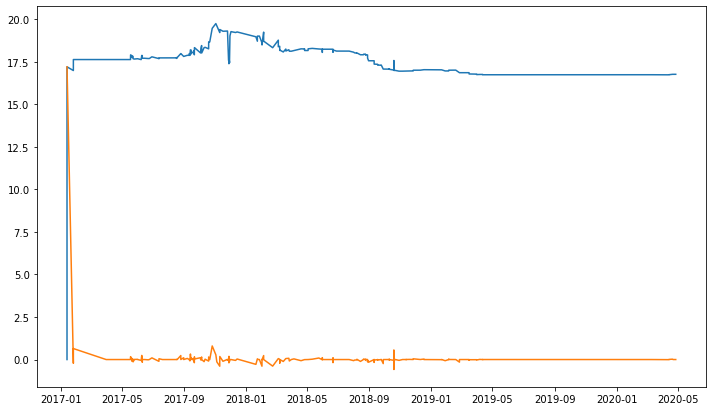

In [67]:
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data.values())
plotByDate(deltas.values())

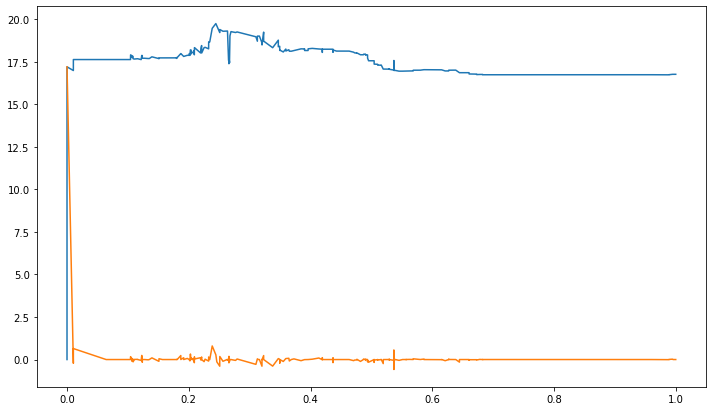

In [69]:
pyplot.figure(figsize=(12, 7))
plotByLifecycle(data)
plotByLifecycle(deltas)

### Run metrics for all repos

In [29]:
# from multiprocessing.pool import ThreadPool
# import consumers

start = time.time()
with Pool(int(multiprocessing.cpu_count()/4)) as pool:
    #allMetrics = pool.map(lambda repo: averageMetricPerCommitForRepo(repoTuple=repo, metricFunction=locmOf), basicJavaRepos)
    allMetrics = pool.map(functools.partial(averageMetricPerCommitForRepo, metricFunction=repoAnalysis.locmOf), basicJavaRepos)
allMetrics = list(map(lambda wrap: wrap.data, allMetrics))
chainMap = collections.ChainMap(*allMetrics)
end = time.time()
print('Total Time used: '+str(end - start))

Time used for ('bptlab', 'fcm2cpn.git'): 0.410602331161499
Time used for ('bptlab', 'correlation-analysis.git'): 3.3247828483581543
Time used for ('bptlab', 'scylla.git'): 27.353537559509277
Time used for ('json-iterator', 'java.git'): 29.815542936325073
Time used for ('bptlab', 'cepta.git'): 32.99368500709534
Time used for ('bptlab', 'Unicorn.git'): 38.291534662246704
Time used for ('alibaba', 'arthas.git'): 160.3558988571167
Total Time used: 161.17432641983032


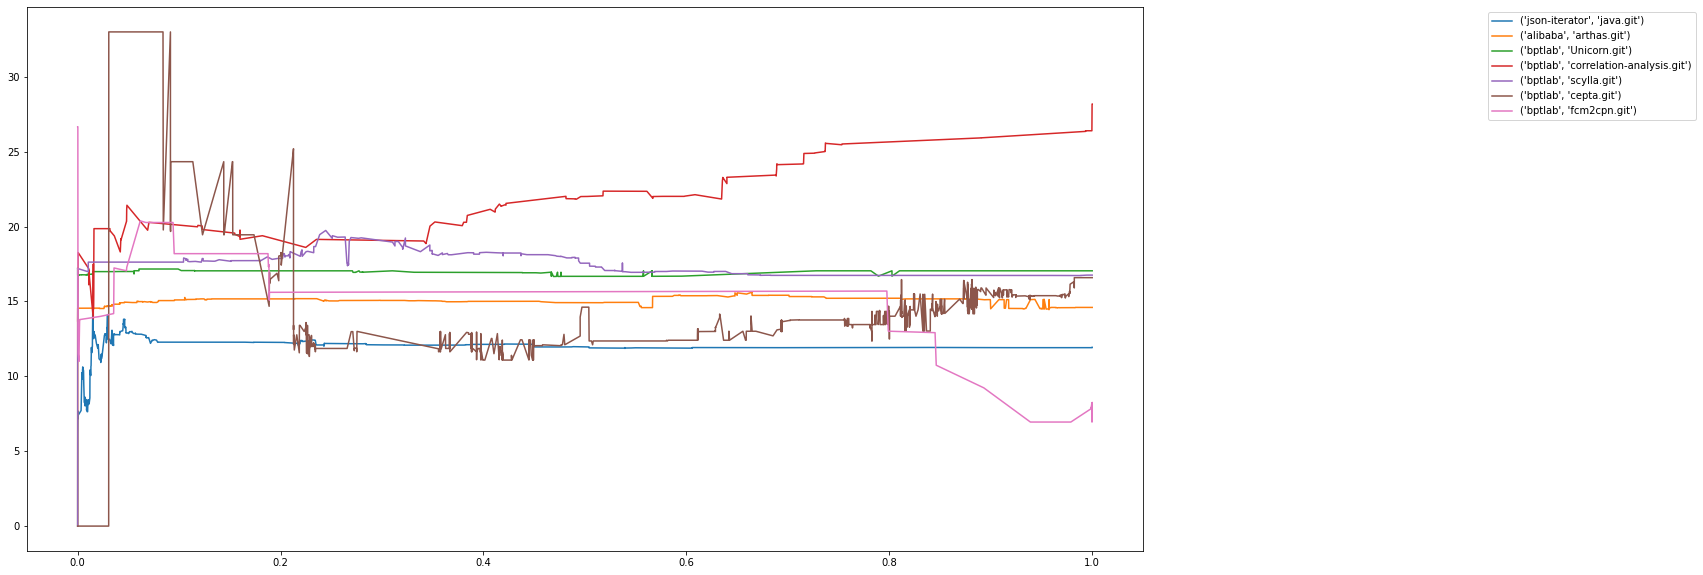

In [35]:
# reposToMetrics = dict(zip(repos, allMetrics))

pyplot.figure(figsize=(20, 10))
for data in allMetrics:
    plotByLifecycle(
        #deltasOf(
            data.values()
        #)
    )

pyplot.legend(basicJavaRepos, bbox_to_anchor=(1.5, 1.0))

In [20]:
sha = next(iter(next(iter(allMetrics))))
print(chainMap.get(sha, default=None))

(1552402499, 11.935117352548417, None)


# Starting to run suites and generate database

In [11]:
%load_ext autoreload
%aimport repoAnalysis
%aimport dbUtils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%autoreload 2
suite = repoAnalysis.metricSuite
data = repoAnalysis.calculateMetrics(('bptlab', 'scylla', 123456789), suite)
data

Time used for ('bptlab', 'scylla', 123456789): 37.73695778846741


,sha,parent,timestamp,repoId,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,ee00a205a2225ad73b0264cf7ba64be5c7044d0b,aa9335c1b629e660d48cf6cb923bf345f79f0619,1587919939,123456789,29423,25301,271,1609,225,4184,93,1736,56348.00
1,aa9335c1b629e660d48cf6cb923bf345f79f0619,b215b9f8ea72fcbadb5881c73ed949a21f456601,1587456806,123456789,29421,25301,271,1609,225,4184,93,1736,56348.00
2,b215b9f8ea72fcbadb5881c73ed949a21f456601,d27a25f6aca8eb7820b5ee4e2d87f65ecf7c454e,1587369531,123456789,29419,25299,271,1609,225,4184,93,1736,56344.00
3,d27a25f6aca8eb7820b5ee4e2d87f65ecf7c454e,42b3c179a26bbd0c06a84d257f4a0d5497f54a5a,1586774875,123456789,29413,25293,271,1609,225,4178,93,1736,56338.75
4,42b3c179a26bbd0c06a84d257f4a0d5497f54a5a,52d70ef3d86c0c92cca31e33b068792c4cc09f44,1586773854,123456789,29450,25328,271,1611,225,4208,93,1736,56372.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,3a525dd8c0178158275815e47e6f7970372489df,a019eafb85e1d093b5a9ac75792d3c3793e0fcfe,1485388416,123456789,13323,11156,164,704,15,1477,33,122,26513.00
293,a019eafb85e1d093b5a9ac75792d3c3793e0fcfe,None,1485387515,123456789,12972,10850,158,691,15,1454,31,117,25773.50
294,411d51771ee6c714db13c23e8912086840b84f51,9e8faf6f0b516334451c53960dee001a6e9e42c4,1485386460,123456789,12972,10850,158,691,15,1454,31,117,25773.50
295,9e8faf6f0b516334451c53960dee001a6e9e42c4,e1ca54916ff570656eb1d40c13b7e58c10d8bc0a,1484305822,123456789,12922,10795,155,686,15,1466,30,117,25716.50


In [71]:
from sqlalchemy import MetaData, Table, Column, Integer, String
columns = [Column('sha', String), Column('parent', String), Column('timestamp', Integer), Column('repoId', Integer)]
columns = columns + list(map(lambda func: Column(func.__name__, Integer), suite))
meta = MetaData(schema='crm20')
tableName = 'lb_test2'
table = Table(
    tableName, meta,
    *columns
)
meta.create_all(dbUtils.engine)

In [78]:
data.to_sql(tableName, schema='crm20', con=dbUtils.engine, if_exists='append', index=False)

In [97]:
dbUtils.runQuery('''
    select column_name, data_type from information_schema.columns
    where table_name = '''+"'"+tableName+'''';
''')

Time used: 0.004015207290649414


,column_name,data_type


In [18]:
import time
import datetime
from multiprocessing import Pool
from multiprocessing import Semaphore
import multiprocessing
import sqlalchemy
import pandas
from IPython.utils import io

In [11]:
%load_ext autoreload
%autoreload 2
%aimport repoAnalysis
%aimport repoLibrarian
%aimport dbUtils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
suite = repoAnalysis.metricSuite
tableName = 'lb_results'

from sqlalchemy import MetaData, Table, Column, Integer, String
def createTable():
    columns = [Column('sha', String), Column('parent', String), Column('timestamp', Integer), Column('repoId', Integer)]
    columns = columns + list(map(lambda func: Column(func.__name__, Integer), suite))
    meta = MetaData(schema='crm20')
    table = Table(
        tableName, meta,
        *columns
    )
    meta.create_all(dbUtils.engine)
    dbUtils.engine.dispose()

def deleteTable():
    try:
        dbUtils.runQuery('''
            DROP TABLE crm20.'''+tableName+'''
        ''')
    except:
        pass
    
dataBaseSemaphore = multiprocessing.Semaphore()
logSemaphore = multiprocessing.Semaphore()

def log(text):
    with logSemaphore:
        with open('log.txt', 'a') as file:
            file.write('========= '+str(datetime.datetime.now())+' ==========\n'+str(text))

def runSuite(repo):
    with io.capture_output() as output:
        data = repoAnalysis.calculateMetrics(repo, suite)
        with dataBaseSemaphore:
            data.to_sql(tableName, schema='crm20', con=dbUtils.engine, if_exists='append', index=False)
            dbUtils.engine.dispose()
    log(output)
    return len(data) > 0

In [9]:
repoLibrarian.setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

In [14]:
polyglotProjects = dbUtils.runQuery('''SELECT * FROM lb_polyglotProjects''')
controlgroupProjects = dbUtils.runQuery('''SELECT * FROM lb_controlgroupProjects''')
bothProjects = pandas.concat([polyglotProjects, controlgroupProjects], axis=0)

Time used: 0.37739133834838867


Time used: 0.36337733268737793


In [16]:
def rowToTuple(x):
    (index, row) = x
    split = row['url'].split('/')
    user = split[-2]
    project = split[-1]
    return (user, project, row['repo_id'])
repos = list(filter(lambda tupl: repoLibrarian.isJavaRepo(tupl[0], tupl[1]), map(rowToTuple, bothProjects.iterrows())))

Failed to check ('thiagoruis', 'dotNET-Grupo-2'): Reference at 'refs/heads/master' does not exist
Could not download repo "tananaev/traccar-client": Cmd('git') failed due to: exit code(128)
  cmdline: git clone --bare -v https://github.com/tananaev/traccar-client.git /mnt/brick/crm20/repos/tananaev/traccar-client.git
  stderr: 'Cloning into bare repository '/mnt/brick/crm20/repos/tananaev/traccar-client.git'...
fatal: could not read Username for 'https://github.com': No such device or address
'
Failed to check ('tananaev', 'traccar-client'): Reference at 'refs/heads/master' does not exist
Could not download repo "topicusonderwijs/wicket-openid": Cmd('git') failed due to: exit code(128)
  cmdline: git clone --bare -v https://github.com/topicusonderwijs/wicket-openid.git /mnt/brick/crm20/repos/topicusonderwijs/wicket-openid.git
  stderr: 'Cloning into bare repository '/mnt/brick/crm20/repos/topicusonderwijs/wicket-openid.git'...
fatal: could not read Username for 'https://github.com': No

In [145]:
print(len(bothProjects))

1377


In [142]:
print(len(repos))

620


In [ ]:
deleteTable()
createTable()
#repos = list(map(lambda tupl: (*tupl, int.from_bytes(bytearray(str(tupl), 'utf-8'), byteorder='big', signed=False) % 10000000), repoLibrarian.managedRepos()))
start = time.time()
with Pool(int(multiprocessing.cpu_count()/4)) as pool:
    allMetrics = pool.map(runSuite, repos)
end = time.time()
log('Total Time used: '+str(end - start))

In [20]:
dbUtils.runQuery('''
    SELECT *
    FROM crm20.'''+tableName+'''
''')

Time used: 3.33559250831604


,sha,parent,timestamp,repoId,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,98b67df941da932779fae6fd53295c65ba97a5e8,eb84d072b651f7bde3f74e43ef3b4703c8ef198a,1410048617,10791195,2206,2061,36,191,0,260,22,15,3648
1,eb84d072b651f7bde3f74e43ef3b4703c8ef198a,9b84d21d2a73cf2957627f83192ff2d33ff03786,1406830122,10791195,1709,1590,30,158,0,209,22,0,2767
2,9b84d21d2a73cf2957627f83192ff2d33ff03786,728b4cfc6553831dc955433df9ef92bc37ef87f3,1406640224,10791195,1226,1115,26,97,0,206,0,0,1913
3,728b4cfc6553831dc955433df9ef92bc37ef87f3,64a478e7d9732439ec9ce751c340226234b36f3a,1406149115,10791195,1186,1075,26,104,0,198,0,0,1908
4,64a478e7d9732439ec9ce751c340226234b36f3a,e9a14b318bf32c19a23f22816296c804018683df,1406149007,10791195,1260,1149,26,104,0,193,0,0,2148
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532883,e6e1051be0bd95e219ba0a81c118529c7788c905,27d6cd404d932af28abc02d701ef36f7275eee4f,1415709534,13517417,118,104,3,17,0,39,0,0,91
532884,27d6cd404d932af28abc02d701ef36f7275eee4f,816342774973787f01a56a54e98f634abbc99d82,1415709361,13517417,78,64,3,9,0,31,0,0,51
532885,816342774973787f01a56a54e98f634abbc99d82,54cc47cfbcea4a9309a9cdf2b9929a64638ff67c,1415709130,13517417,71,60,2,9,0,31,0,0,50
532886,54cc47cfbcea4a9309a9cdf2b9929a64638ff67c,ba0074f7c0fb22d76090e569a8e4c73f71e19890,1415708826,13517417,11,8,1,1,0,0,0,0,4


In [148]:
dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_delta_results;
    CREATE VIEW crm20.lb_delta_results AS (
        SELECT
            child.sha, 
            TIMESTAMP 'epoch' + child.timestamp * INTERVAL '1 second' as date,
            lb_java_users.first_written,
            lb_java_users.author_id,
            child."repoId" AS repoid, 
            lb_java_changes.changes AS changes,
            lb_java_changes.deletions AS deletions,
            child.loc - parent.loc AS d_loc,
            child.cloc - parent.cloc AS d_cloc,
            child."fileCount" - parent."fileCount" AS d_filecount,
            child."numMethods" - parent."numMethods" AS d_methods,
            child."numLambdas" - parent."numLambdas" AS d_lambdas,
            child."numCommentLines" - parent."numCommentLines" AS d_commentlines,
            child."numReflection" - parent."numReflection" AS d_reflection,
            child."numSnakes" - parent."numSnakes" AS d_snakes,
            child."totalIndent" - parent."totalIndent" AS d_totalindent
        FROM 
            crm20.'''+tableName+''' child, crm20.'''+tableName+''' parent, 
            crm20.lb_java_commits,
            crm20.lb_java_users,
            crm20.lb_java_changes
        WHERE child.parent = parent.sha
        AND child.sha = lb_java_commits.sha
        AND lb_java_commits.sha = lb_java_changes.sha
        AND lb_java_users.author_id = lb_java_commits.author_id
    );
    SELECT * FROM crm20.lb_delta_results
''')

Time used: 1.0645616054534912


,sha,date,first_written,author_id,repoid,changes,deletions,d_loc,d_cloc,d_filecount,d_methods,d_lambdas,d_commentlines,d_reflection,d_snakes,d_totalindent
0,d819a0cc475b8e647861cde0e98b5d228935da15,2014-02-13 22:58:09,2009-02-27 14:23:06,512799,6032557,1,1,-1,0,0,0,0,0,0,0,0
1,32315e7448e841bc50721682e0a96999bc65b2ff,2014-06-13 09:44:04,2014-06-04 22:39:28,578904,10115094,9,8,-7,-6,0,0,0,-1,0,0,-3
2,d7660498d890495a779e79239e9c48e9aa45fb48,2015-01-06 18:12:32,2009-02-27 14:23:06,512799,6032557,105,0,107,54,2,5,0,0,0,1,69
3,d7660498d890495a779e79239e9c48e9aa45fb48,2015-01-06 18:12:32,2009-02-27 14:23:06,512799,9657832,105,0,107,54,2,5,0,0,0,1,69
4,d7660498d890495a779e79239e9c48e9aa45fb48,2015-01-06 18:12:32,2009-02-27 14:23:06,512799,74713469,105,0,107,54,2,5,0,0,0,1,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,664e4febe5962eacd95e97dc9ea6c517129e5b02,2014-09-09 03:35:06,2014-08-23 13:35:59,4995396,11732879,41,23,-5,-5,0,0,0,1,0,0,-36
38868,7af09ad41c50bb793721d7da2d4389a43dfb6bc3,2004-07-27 16:21:04,2003-05-05 15:52:55,4540797,3805610,60,0,31,22,1,2,0,0,0,0,35
38869,7af09ad41c50bb793721d7da2d4389a43dfb6bc3,2004-07-27 16:21:04,2003-05-05 15:52:55,4540797,13139035,60,0,31,22,1,2,0,0,0,0,35
38870,7af09ad41c50bb793721d7da2d4389a43dfb6bc3,2004-07-27 16:21:04,2003-05-05 15:52:55,4540797,5620362,60,0,31,22,1,2,0,0,0,0,35


# Metrics by year

In [149]:
metricsByYear = dbUtils.runQuery('''
    SELECT
        EXTRACT(YEAR FROM date) as year, 
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results
    WHERE changes > 0
    GROUP BY year
    ORDER BY year
''')
display(metricsByYear)

Time used: 0.27174854278564453


,year,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,2003.0,360.474684,325.924051,1.949367,0.009011,-0.002122,0.002044,0.000581,0.011819,0.162520
1,2004.0,43.908333,37.958333,0.266667,0.005817,-0.004230,0.015715,0.000648,-0.002070,0.282066
2,2009.0,-27.784504,-22.548426,0.121065,0.014056,0.000118,-0.026212,0.001258,0.011432,0.122153
3,2010.0,398.320988,340.327160,3.981481,0.025931,-0.000051,0.033712,0.002672,0.012551,0.440605
4,2011.0,58.677848,48.219078,1.074074,0.024196,0.000014,0.025679,0.001611,0.023570,0.331840
5,2012.0,46.725801,39.805762,0.374555,0.015977,0.000075,0.029566,0.001388,0.015054,0.468809
6,2013.0,14.752167,19.356961,-7.831973,0.021804,0.000331,0.019817,0.001223,0.015442,0.625551
7,2014.0,-0.326818,0.353052,0.066015,0.024415,0.003848,0.025676,0.000391,0.027217,0.630343
8,2015.0,52.173188,43.379747,0.461450,0.023938,0.005634,0.021670,0.001089,0.028836,0.576614
9,2016.0,101.451934,90.998158,0.471087,0.019661,0.003020,0.032344,0.009056,0.046487,0.798806


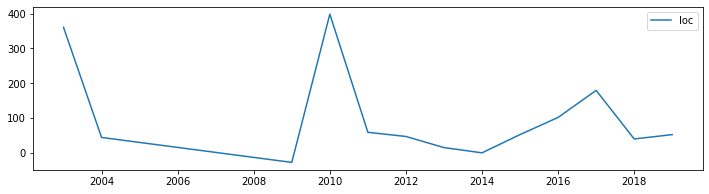

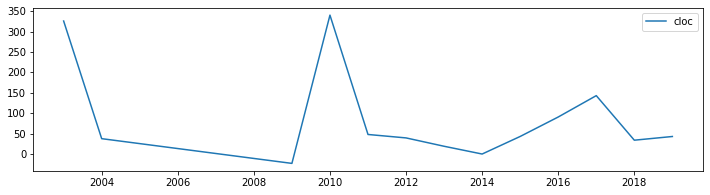

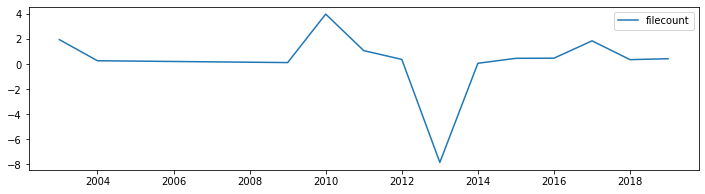

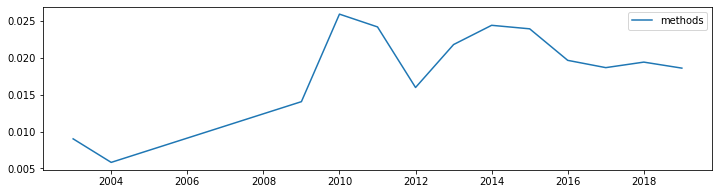

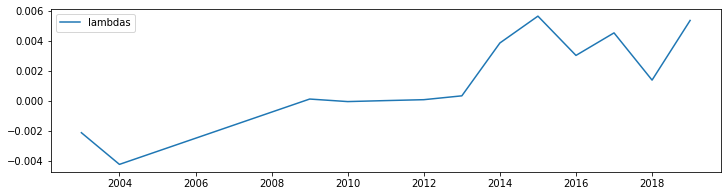

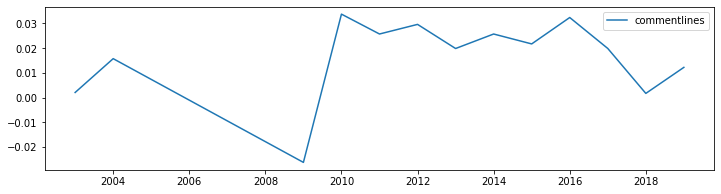

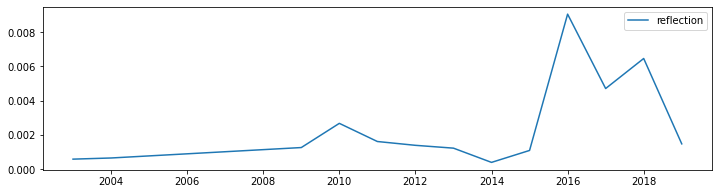

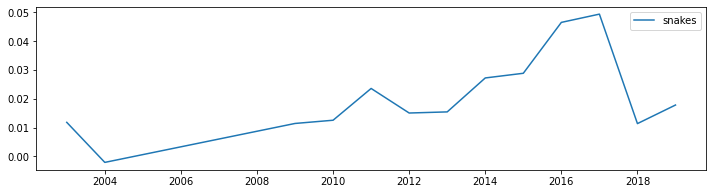

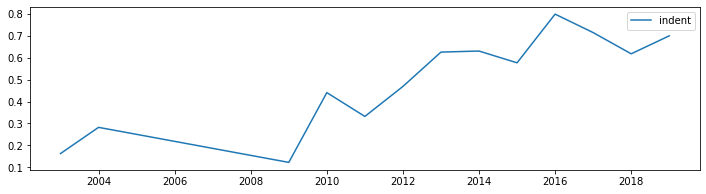

In [150]:
for metric in metricsByYear:
    if metric == 'year': continue 
    pyplot.figure(figsize=(12, 3))
    pyplot.plot(metricsByYear['year'], metricsByYear[metric])
    pyplot.legend([metric])

# Metrics by lifecycle

In [181]:
lifecylePhases = 20.0
percentPerPhase = 100.0 / lifecylePhases
lifecycle = ('''FLOOR(EXTRACT(EPOCH FROM ((date - first_written))) / EXTRACT(EPOCH FROM ((TIMESTAMP '2020-1-1 00:00:00') - first_written)) * '''
             +str(lifecylePhases)+''') * '''+str(percentPerPhase)+''' as lifecycle''')

In [161]:
metricsByLifecycle = dbUtils.runQuery('''
    SELECT
        '''+lifecycle+''',       
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results
    WHERE changes > 0
    AND changes < 1000
    GROUP BY lifecycle
    ORDER BY lifecycle
''')
display(metricsByLifecycle)

Time used: 0.25681257247924805


,lifecycle,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,0.0,45.259518,35.699888,0.548992,0.018707,-0.002024,0.016319,0.000961,0.022474,0.421142
1,1.0,47.793040,39.905983,0.421856,0.014755,0.000211,0.010612,0.000111,0.018308,0.413150
2,2.0,37.349508,32.483826,0.214487,0.014240,0.000348,-0.013990,0.000485,0.015264,0.284888
3,3.0,46.168430,40.686067,0.319224,0.013164,0.000726,0.041874,0.000324,0.023234,0.442964
4,4.0,40.563454,36.089218,0.211355,0.009603,-0.005875,0.019017,0.000622,0.000257,0.307969
...,...,...,...,...,...,...,...,...,...,...
89,89.0,23.401515,19.068182,0.121212,0.012890,0.003745,0.001731,0.000360,0.021713,0.918723
90,90.0,13.873016,14.031746,0.047619,0.019255,0.027608,-0.000305,0.003930,0.026368,0.538801
91,91.0,7.634783,7.173913,0.034783,0.030796,0.022342,0.010642,0.001087,-0.002825,0.799819
92,92.0,11.707317,10.829268,0.000000,0.022370,-0.014346,-0.010368,-0.006076,0.004377,0.449928


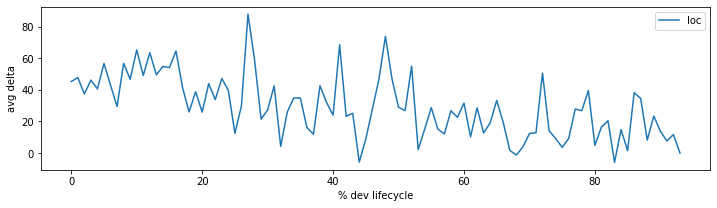

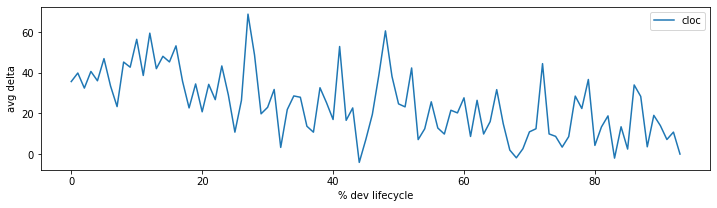

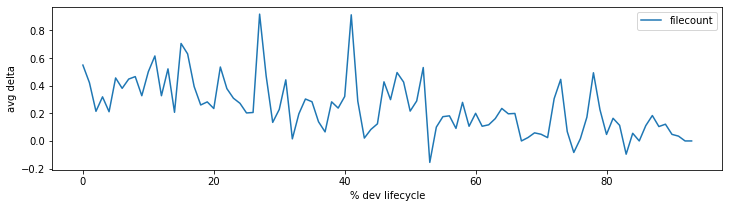

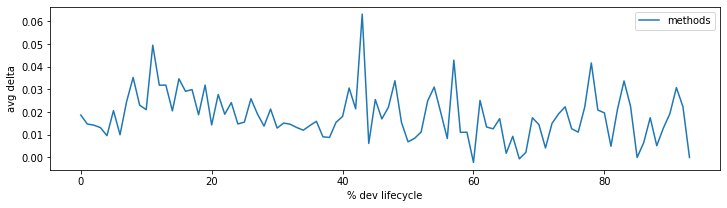

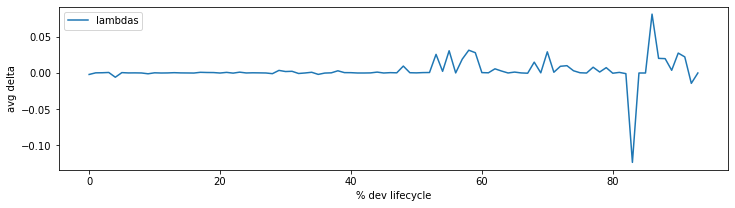

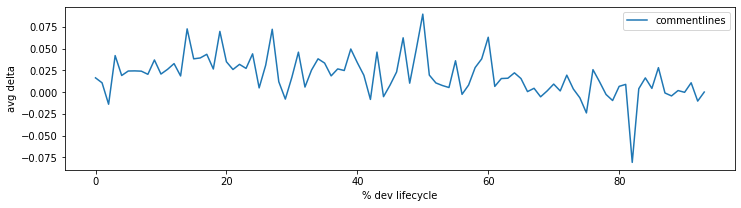

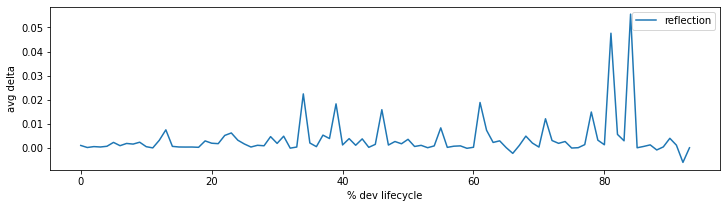

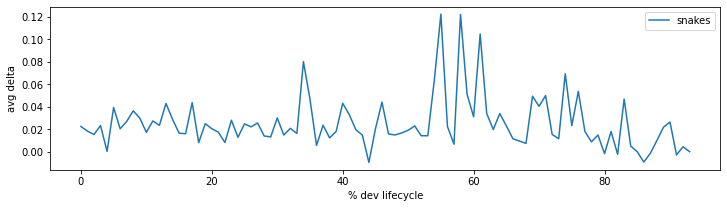

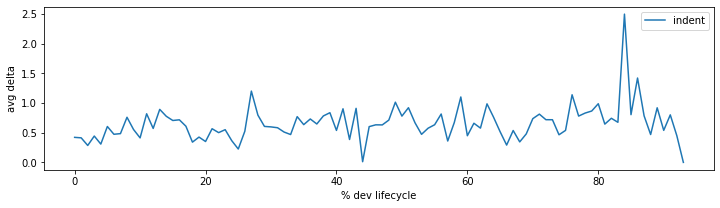

In [172]:
for metric in metricsByLifecycle:
    if metric == 'lifecycle': continue 
    pyplot.figure(figsize=(12, 3))
    pyplot.xlabel('% dev lifecycle')
    pyplot.ylabel('avg delta')
    pyplot.plot(metricsByLifecycle['lifecycle'], metricsByLifecycle[metric])
    pyplot.legend([metric])

In [242]:
metricsPolyglot = dbUtils.runQuery('''
    SELECT
        '''+lifecycle+''',      
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results, crm20.lb_polyglots
    WHERE changes > 0
    AND changes < 1000
    AND ABS(d_loc) < 1000
    AND lb_polyglots.author_id = lb_delta_results.author_id
    AND date > ALL(secstart)
    GROUP BY lifecycle
    ORDER BY lifecycle
''')
display(metricsPolyglot)

Time used: 0.5198020935058594


,lifecycle,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,15.0,3.0,3.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,171.428571
1,25.0,283.0,205.0,2.0,42.704626,0.0,0.000000,3.558719,56.939502,1120.996441
2,30.0,59.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,50.0,65.0,35.0,1.0,62.500000,0.0,15.625000,0.000000,0.000000,937.500000
4,25.0,36.0,16.0,1.0,28.571429,0.0,171.428571,0.000000,0.000000,257.142857
...,...,...,...,...,...,...,...,...,...,...
23689,50.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
23690,10.0,147.0,117.0,2.0,40.816327,0.0,190.476190,0.000000,0.000000,1911.564626
23691,60.0,4.0,4.0,0.0,166.666667,0.0,0.000000,166.666667,0.000000,666.666667
23692,0.0,-30.0,-18.0,0.0,-5.319149,0.0,-143.617021,0.000000,-37.234043,-797.872340


In [243]:
metricsControlGroup = dbUtils.runQuery('''
    SELECT
        '''+lifecycle+''', 
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results
    WHERE changes > 0
    AND changes < 1000
    AND author_id IN (SELECT author_id FROM crm20.lb_controlgroup)
    GROUP BY lifecycle
    ORDER BY lifecycle
''')
display(metricsControlGroup)

Time used: 0.2493281364440918


,lifecycle,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,40.0,181.0,141.0,1.0,44.117647,0.0,102.941176,0.0,0.000000,1205.882353
1,30.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,30.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,35.0,13.0,12.0,0.0,76.923077,0.0,76.923077,0.0,230.769231,2076.923077
4,35.0,13.0,12.0,0.0,76.923077,0.0,76.923077,0.0,230.769231,2076.923077
...,...,...,...,...,...,...,...,...,...,...
5419,0.0,9.0,3.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,790.697674
5420,0.0,-9.0,-11.0,0.0,-5.347594,0.0,0.000000,0.0,165.775401,-160.427807
5421,5.0,10.0,10.0,0.0,0.000000,0.0,500.000000,0.0,83.333333,3166.666667
5422,5.0,5.0,2.0,0.0,0.000000,0.0,-52.631579,0.0,-52.631579,894.736842


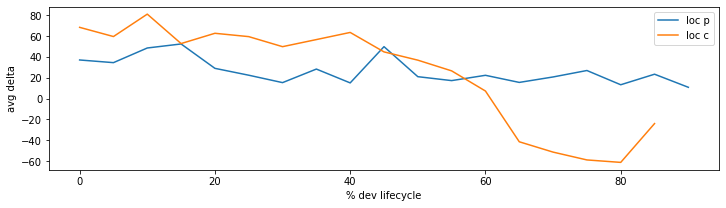

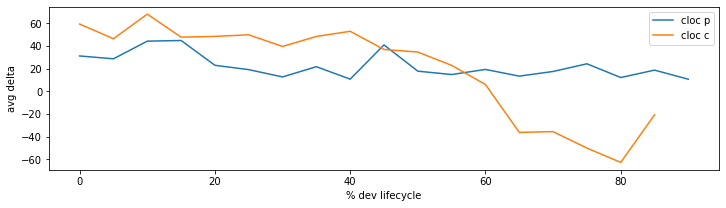

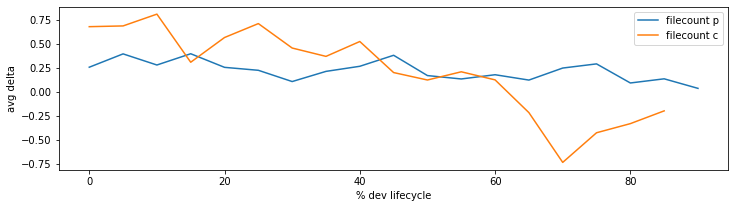

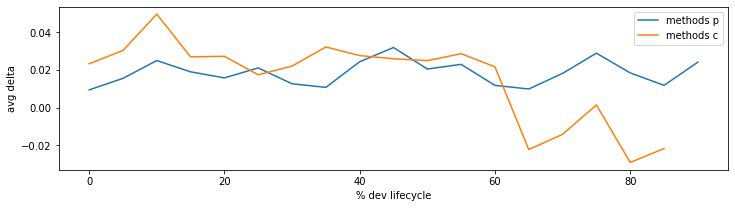

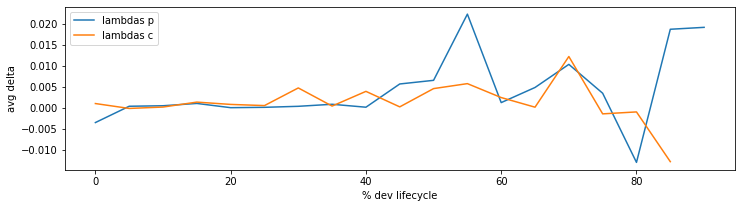

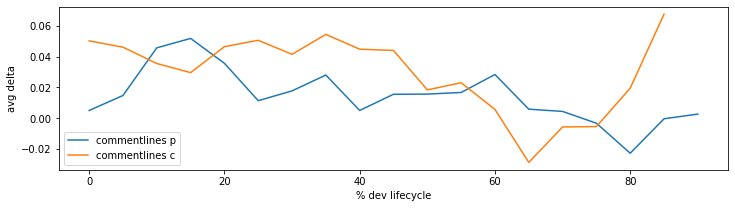

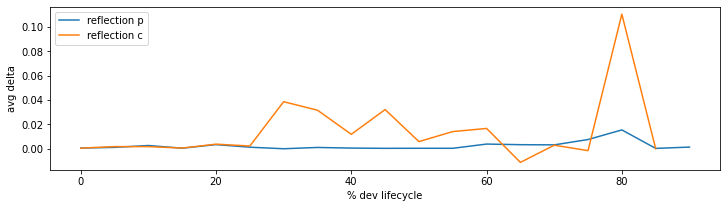

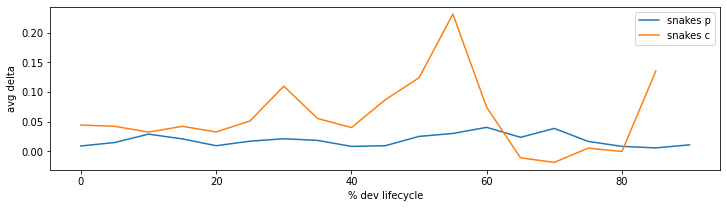

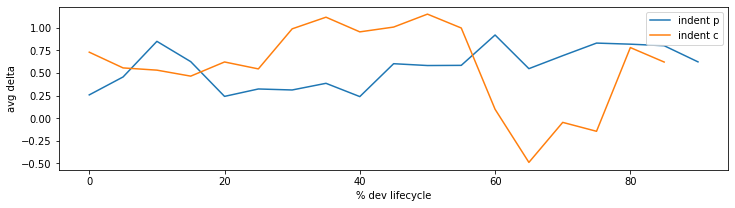

In [184]:
for metric in metricsPolyglot:
    if metric == 'lifecycle': continue 
    pyplot.figure(figsize=(12, 3))
    pyplot.xlabel('% dev lifecycle')
    pyplot.ylabel('avg delta')
    pyplot.plot(metricsPolyglot['lifecycle'], metricsPolyglot[metric])
    pyplot.plot(metricsControlGroup['lifecycle'], metricsControlGroup[metric])
    pyplot.legend([metric+' p', metric+' c'])
    pyplot.savefig('figures/'+metric+'.png')

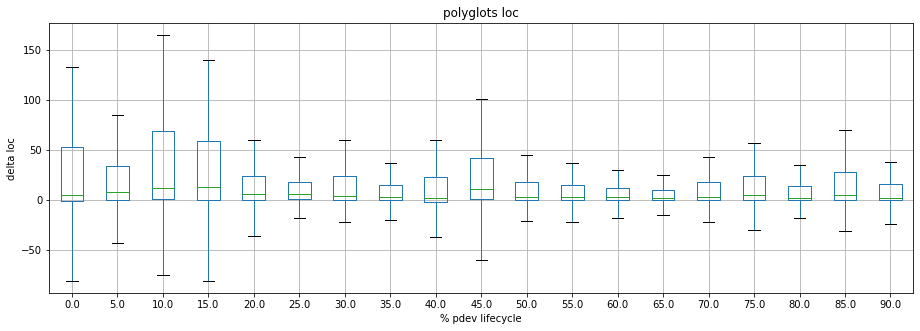

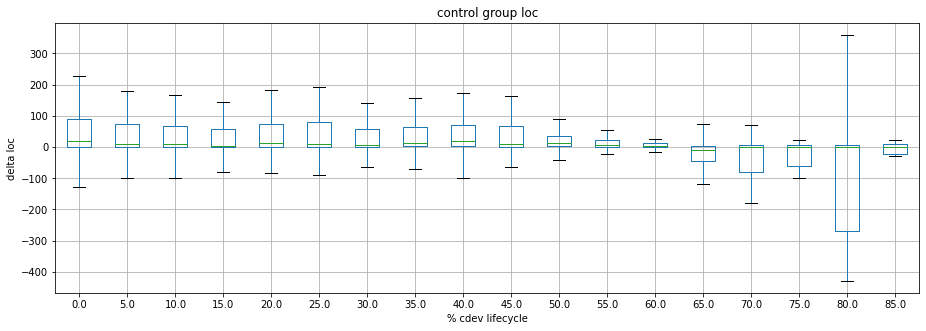

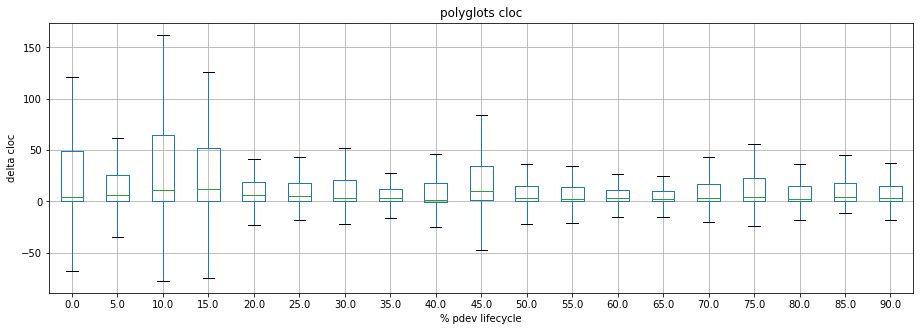

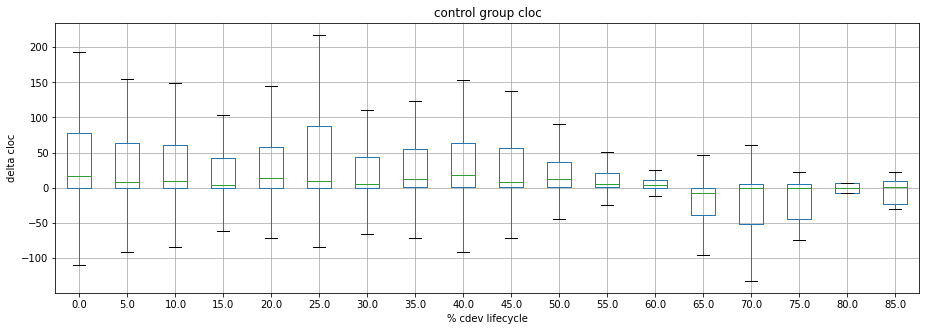

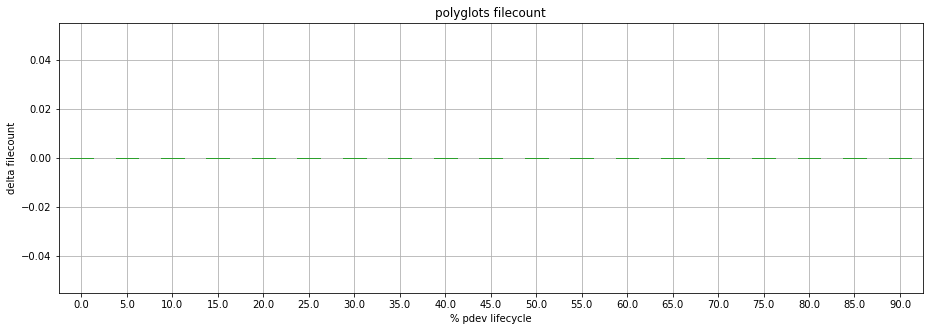

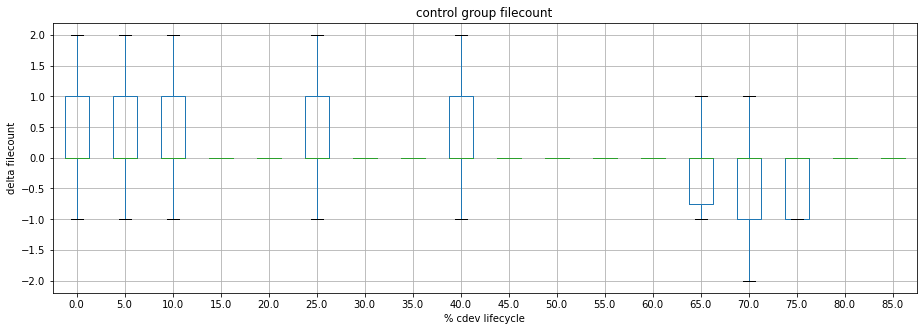

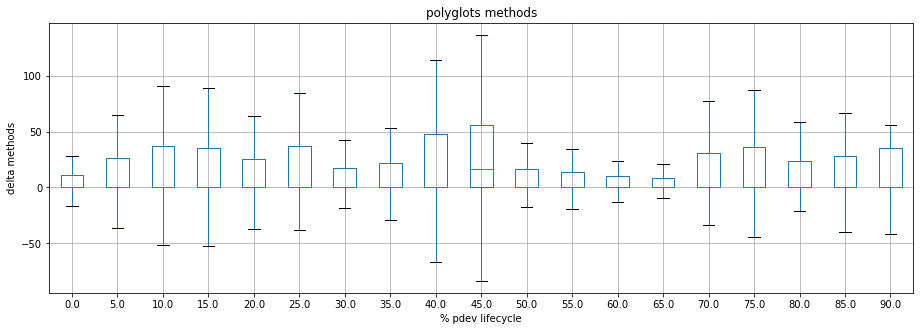

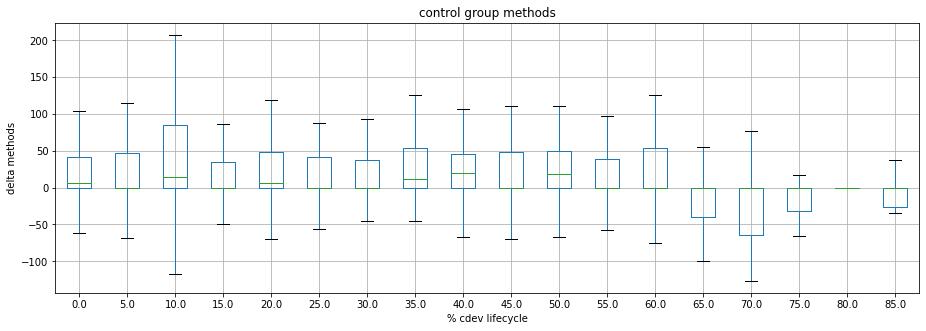

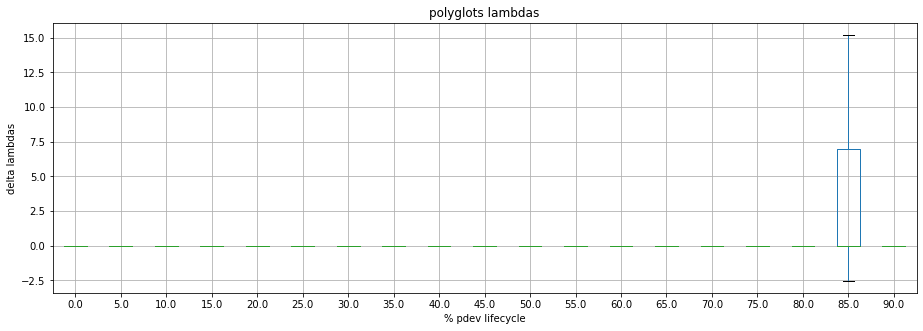

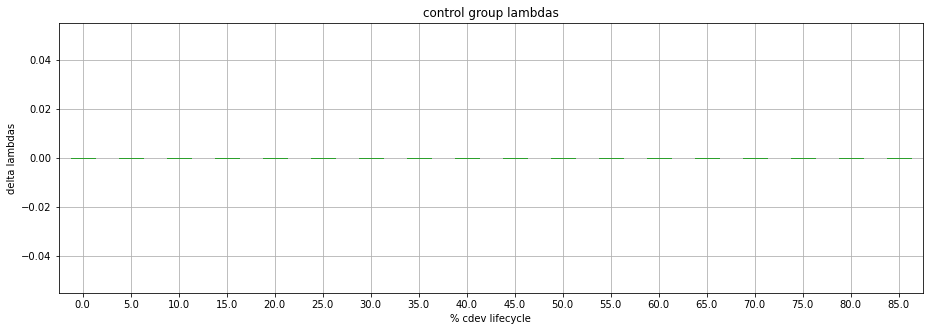

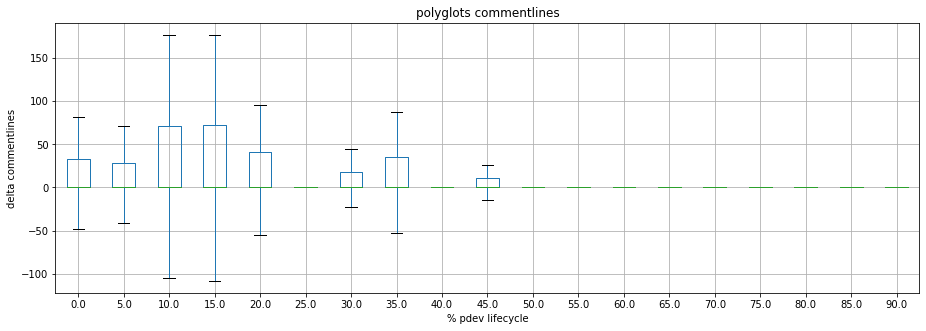

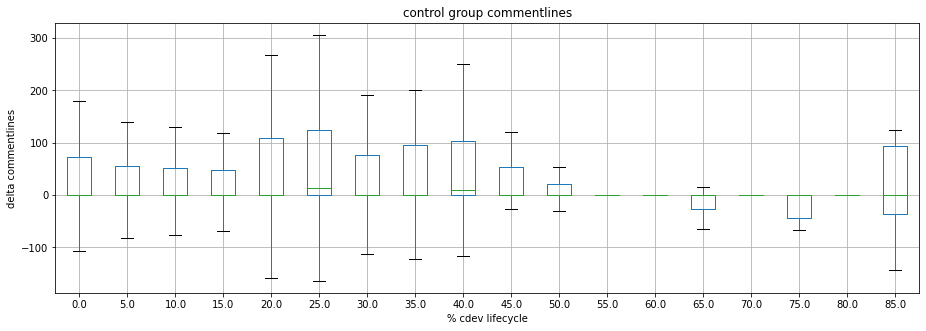

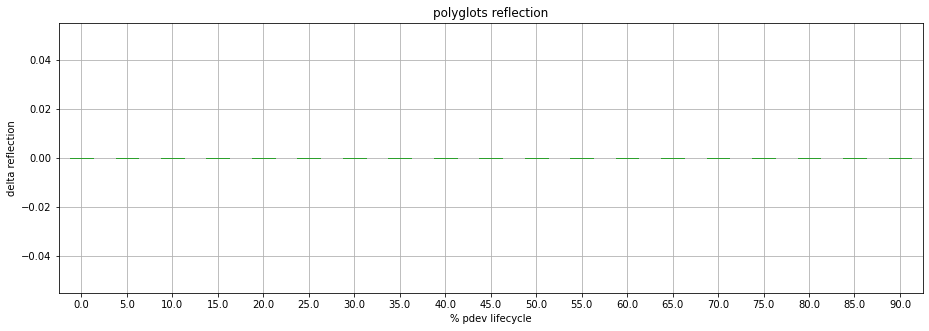

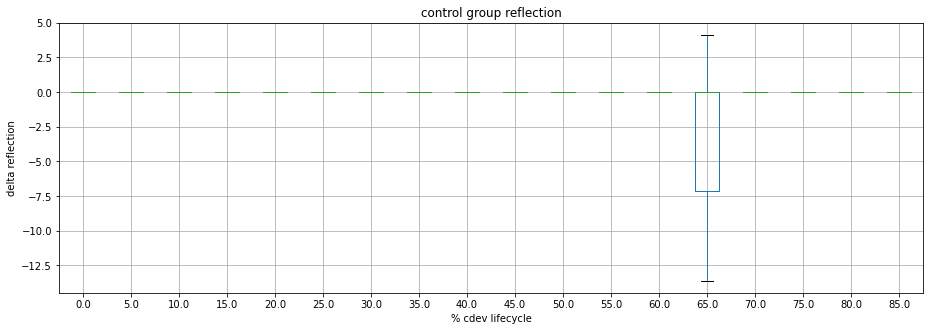

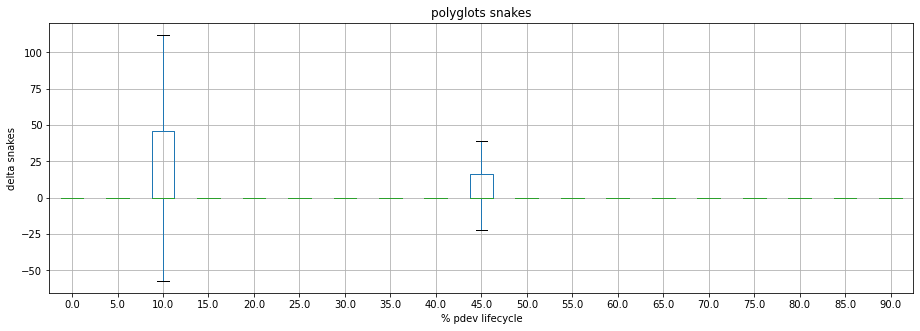

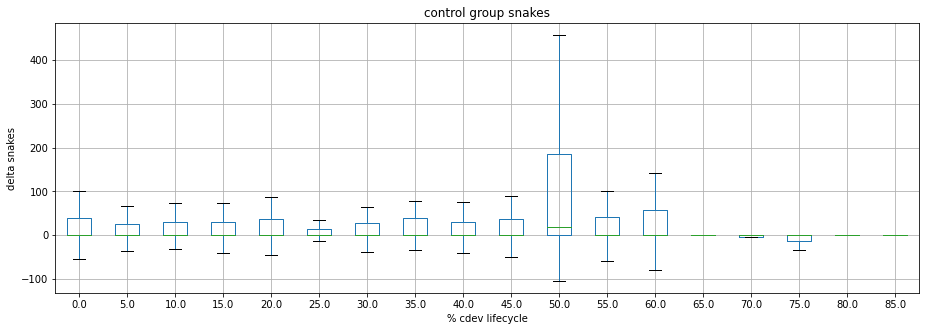

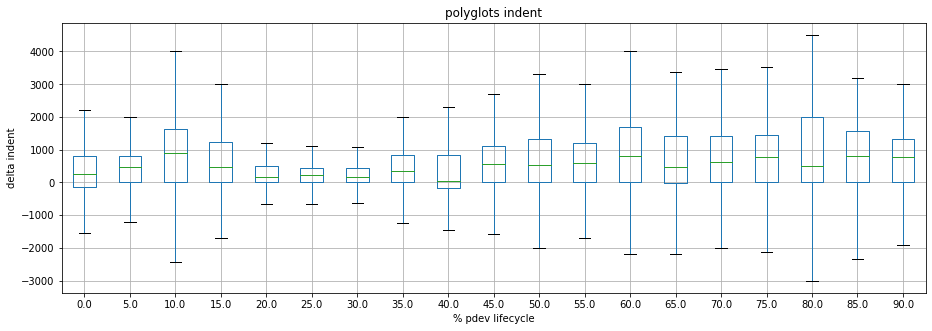

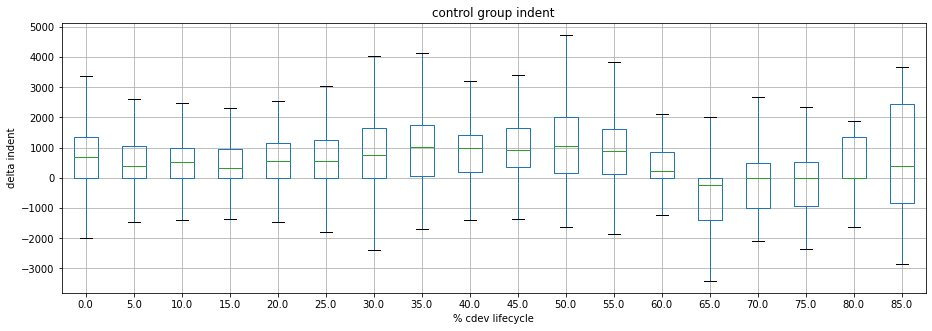

In [246]:
for metric in metricsPolyglot:
    if metric == 'lifecycle': continue 
    
    x = metricsPolyglot.boxplot(column=metric, by='lifecycle', showfliers=False, figsize=(15, 5))
    pyplot.xlabel('% pdev lifecycle')
    pyplot.ylabel('delta '+metric)
    pyplot.title('polyglots '+metric)
    pyplot.suptitle('')
    
    y = metricsControlGroup.boxplot(column=metric, by='lifecycle', showfliers=False, figsize=(15, 5))
    pyplot.xlabel('% cdev lifecycle')
    pyplot.ylabel('delta '+metric)
    pyplot.title('control group '+metric)
    pyplot.suptitle('')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f54fb2e6d60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5539f5bc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f54fb2e6610>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5539f5baf0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5539f5b130>,
 'means': []}

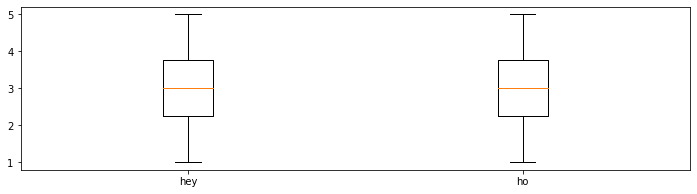

In [188]:
pyplot.figure(figsize=(12, 3))
pyplot.boxplot([[1, 2, 3, 3, 4, 5],[4, 2, 5, 3, 1, 3]], labels=['hey', 'ho'])